# Value at Risk (VaR)

[*********************100%%**********************]  1 of 1 completed


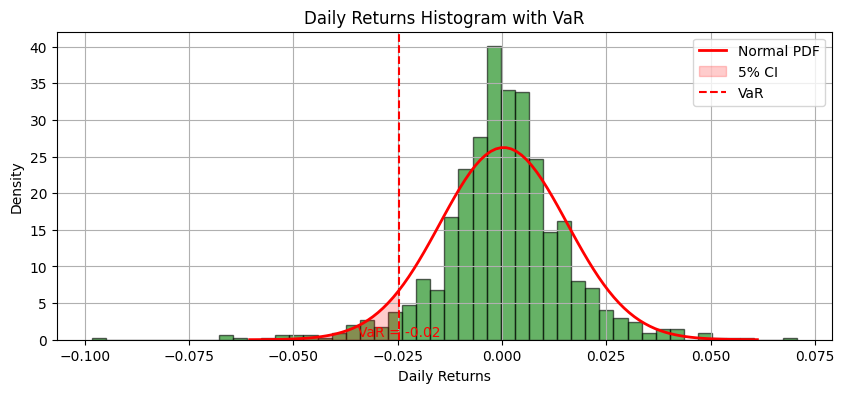

Value at risk for tomorrow (1 day) at 95.0% confidence level: $-24640.19


In [85]:
import numpy as np
import yfinance as yf
from scipy.stats import norm
import pandas as pd
import datetime
import matplotlib.pyplot as plt

def download_data(stock, start_date, end_date):
    data = {}
    ticker = yf.download(stock, start=start_date, end=end_date)
    data[stock] = ticker['Adj Close']
    return pd.DataFrame(data)

# this is how we calculate the VaR tomorrow (n=1)
def calculate_var(position, c, mu, sigma):
    var = position * (mu + sigma * norm.ppf(1-c))
    return var

# this is how we calculate the VaR for any days in the future
def calculate_var_n(position, c, mu, sigma, n):
    var = position * (mu * n + sigma * np.sqrt(n) * norm.ppf(1-c))
    return var

if __name__ == '__main__':
    start = datetime.datetime(2014, 1, 1)
    end = datetime.datetime(2018, 1, 1)

    stock_data = download_data('C', start, end)

    stock_data['returns'] = np.log(stock_data['C'] / stock_data['C'].shift(1))
    stock_data = stock_data[1:]

    # Plotting the histogram of daily returns
    plt.figure(figsize=(10, 4))
    plt.hist(stock_data['returns'], bins=50, density=True, alpha=0.6, color='g', edgecolor='black')

    # Calculate mean and standard deviation of returns
    mu = np.mean(stock_data['returns'])
    sigma = np.std(stock_data['returns'])

    # Confidence level (e.g., 99%)
    c = 0.95
    S= 1
     
    # Calculate VaR for tomorrow (n=1)
    var_1 = calculate_var(S, c, mu, sigma)

    # Plot VaR on the histogram
    #plt.axvline(var_1, color='r', linestyle='dashed', linewidth=2, label=f'VaR (1 day) at {c*100}% confidence')

    # Plotting the probability density function (PDF) of the normal distribution
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    plt.plot(x, normal_dist.pdf(x), 'r-', lw=2, label='Normal PDF')

    # Shade the area for 95% confidence interval
    alpha = 0.05
    z_critical = norm.ppf(1 - alpha)  # Calculate the critical z-value

    # Calculate 95% confidence interval bounds
    lower_bound = mu - z_critical * sigma
    #upper_bound = mu + 1.96 * sigma


    
    #plt.fill_between(x, 0, y, where=(x >= -z_critical* sigma) & (x <= z_critical* sigma), color='gray', alpha=0.5, label='95% CI')
    # Plotting the confidence interval as shaded region on the histogram
    plt.fill_between(x, 0, norm.pdf(x, mu, sigma), where=(x <= lower_bound) ,
                     color='red', alpha=0.2, label='5% CI')

    # Mark the critical values
    plt.axvline(lower_bound, color='r', linestyle='--', label='VaR')
    #plt.axvline(upper_bound, color='r', linestyle='--')
    
    # Annotation for critical values

    plt.text(lower_bound, 0.1, f'VaR = {lower_bound:.2f}', ha='center', va='bottom', color='r')
    #plt.text(upper_bound, 0.1, f'upper_bound = {upper_bound:.2f}', ha='center', va='bottom', color='r')

    # Labels and title
    plt.title('Standard Normal Distribution with 95% Confidence Interval')


    plt.title('Daily Returns Histogram with VaR')
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    Position = 1e6
    print(f'Value at risk for tomorrow (1 day) at {c*100}% confidence level: ${var_1 * Position:.2f}')


# Monte Carlo Approach

# Method 1

In [99]:
import numpy as np
import yfinance as yf
import datetime
import pandas as pd


def download_data(stock, start, end):
    data = {}
    ticker = yf.download(stock, start, end)
    data['Adj Close'] = ticker['Adj Close']
    return pd.DataFrame(data)


class ValueAtRiskMonteCarlo:

    def __init__(self, S, mu, sigma, c, n, iterations):
        self.S = S
        self.mu = mu
        self.sigma = sigma
        self.c = c
        self.n = n
        self.iterations = iterations

    def simulation(self):
        stock_data = np.zeros([self.iterations, 1])
        rand = np.random.normal(0, 1, [1, self.iterations])

        # equation for the S(t) stock price
        stock_price = self.S * np.exp(self.n * (self.mu - 0.5 * self.sigma ** 2) + self.sigma * np.sqrt(self.n) * rand)

        # we have to sort the stock prices to determine the percentile
        stock_price = np.sort(stock_price)

        # it depends on the confidence level: 95% -> 5 and 99% -> 1
        percentile = np.percentile(stock_price, (1 - self.c) * 100)

        return self.S - percentile


if __name__ == "__main__":
    S = 1e6  # this is the investment (stocks or whatever)
    c = 0.95  # condifence level: this time it is 99%
    n = 1  # 1 day
    iterations = 100000  # number of paths in the Monte-Carlo simulation

    # historical data to approximate mean and standard deviation
    start_date = datetime.datetime(2014, 1, 1)
    end_date = datetime.datetime(2017, 10, 15)

    # download stock related data from Yahoo Finance
    citi = download_data('C', start_date, end_date)

    # we can use pct_change() to calculate daily returns
    citi['returns'] = citi['Adj Close'].pct_change()

    # we can assume daily returns to be normally sidtributed: mean and variance (standard deviation)
    # can describe the process
    mu = np.mean(citi['returns'])
    sigma = np.std(citi['returns'])

    model = ValueAtRiskMonteCarlo(S, mu, sigma, c, n, iterations)

    print('Value at risk with Monte-Carlo simulation: $%0.2f' % model.simulation())

[*********************100%%**********************]  1 of 1 completed

Value at risk with Monte-Carlo simulation: $24602.21


# Method 2

In [100]:
import numpy as np
import yfinance as yf
import pandas as pd
import datetime

def download_data(stock, start_date, end_date):
    data = {}
    ticker = yf.download(stock, start=start_date, end=end_date)
    data[stock] = ticker['Adj Close']
    return pd.DataFrame(data)

def calculate_var(position, c, simulated_returns):
    # Sort simulated returns to find the appropriate quantile
    sorted_returns = np.sort(simulated_returns)
    var = np.percentile(sorted_returns, 100 * (1 - c))
    return position * var

if __name__ == '__main__':
    # Define parameters
    start_date = datetime.datetime(2014, 1, 1)
    end_date = datetime.datetime(2018, 1, 1)
    stock = 'C'
    confidence_level = 0.95
    position = 1e6  # Initial investment amount

    # Download historical data
    stock_data = download_data(stock, start_date, end_date)
    stock_data['returns'] = np.log(stock_data['C'] / stock_data['C'].shift(1))
    stock_data = stock_data.dropna()

    # Parameters for Monte Carlo simulation
    num_simulations = 1000

    # Generate simulated returns
    mu = np.mean(stock_data['returns'])
    sigma = np.std(stock_data['returns'])
    simulated_returns = np.random.normal(mu, sigma, num_simulations)

    # Calculate VaR using Monte Carlo simulation
    var = calculate_var(position, confidence_level, simulated_returns)

    print(f'Value at Risk (VaR) at {confidence_level*100:.0f}% confidence level: ${var:.2f}')


[*********************100%%**********************]  1 of 1 completed

Value at Risk (VaR) at 95% confidence level: $-24809.41


# Stress Testing

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


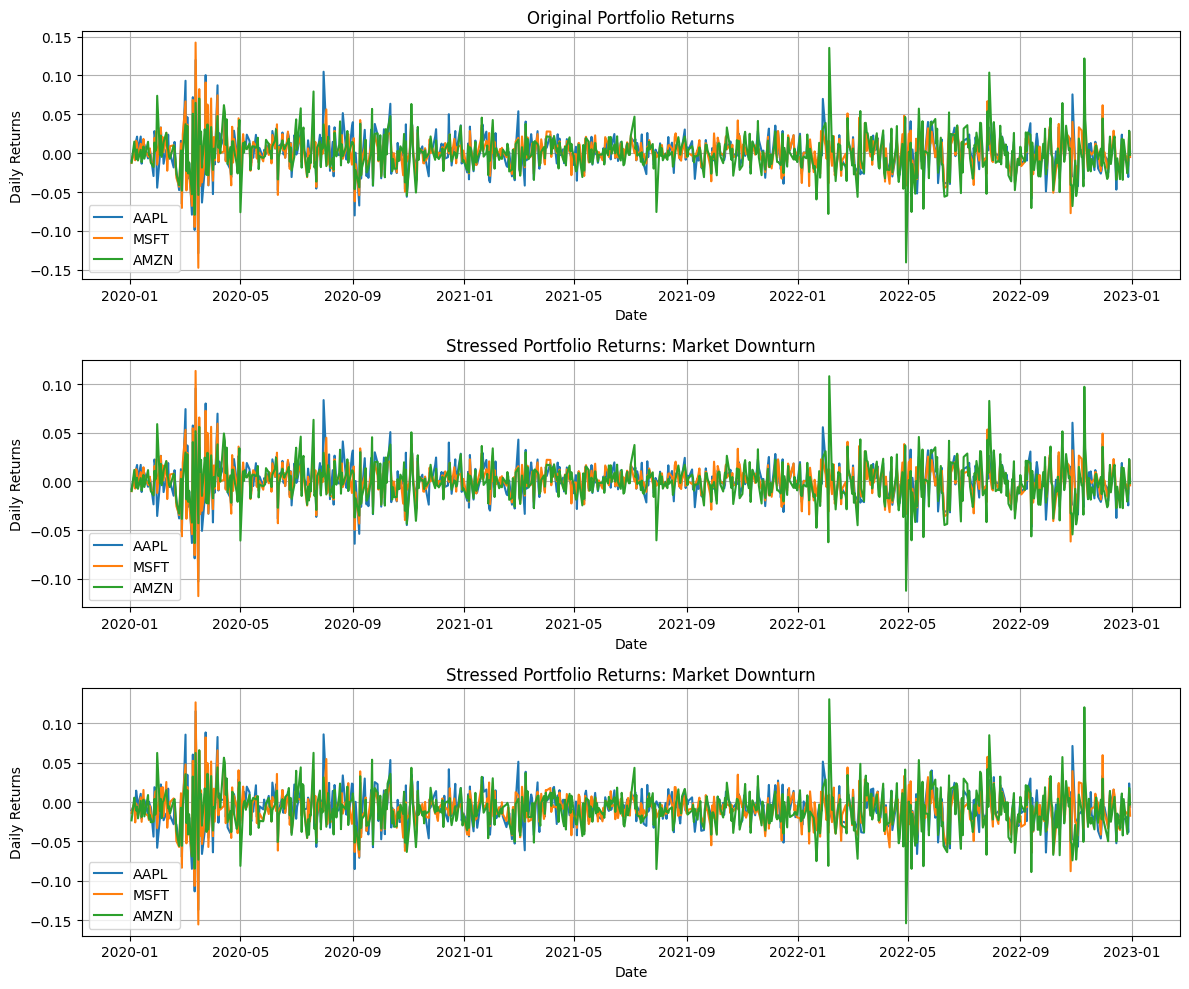

In [101]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Function to download stock data
def download_data(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        ticker_data = yf.download(ticker, start=start_date, end=end_date)
        data[ticker] = ticker_data['Adj Close']
    return pd.DataFrame(data)

# Define portfolio of stocks and download historical data
tickers = ['AAPL', 'MSFT', 'AMZN']
start_date = '2020-01-01'
end_date = '2023-01-01'
portfolio_data = download_data(tickers, start_date, end_date)

# Calculate daily returns of the portfolio
portfolio_returns = portfolio_data.pct_change().dropna()

# Scenario 1: Market Downturn (20% decline in stock prices)
market_downturn_returns = portfolio_returns - 0.20 * portfolio_returns

# Scenario 2: Interest Rate Hike (2% increase in interest rates)
# Assume stocks react negatively with a linear relationship to interest rate hike
interest_rate_hike_returns = portfolio_returns - 0.02 * np.random.random(size=portfolio_returns.shape)

# Plotting the original and stressed portfolio returns
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(portfolio_returns.index, portfolio_returns['AAPL'], label='AAPL')
plt.plot(portfolio_returns.index, portfolio_returns['MSFT'], label='MSFT')
plt.plot(portfolio_returns.index, portfolio_returns['AMZN'], label='AMZN')
plt.title('Original Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(market_downturn_returns.index, market_downturn_returns['AAPL'], label='AAPL')
plt.plot(market_downturn_returns.index, market_downturn_returns['MSFT'], label='MSFT')
plt.plot(market_downturn_returns.index, market_downturn_returns['AMZN'], label='AMZN')
plt.title('Stressed Portfolio Returns: Market Downturn')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(interest_rate_hike_returns.index, interest_rate_hike_returns['AAPL'], label='AAPL')
plt.plot(interest_rate_hike_returns.index, interest_rate_hike_returns['MSFT'], label='MSFT')
plt.plot(interest_rate_hike_returns.index, interest_rate_hike_returns['AMZN'], label='AMZN')
plt.title('Stressed Portfolio Returns: Market Downturn')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
